## Event reproducibility, manifold analysis, and functional connectivity of several cortical areas

We will collect neurons from several cortical areas to perform population *dynamical* and *attractor* analysis, and get the *functional connectivity*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
    - How do events statistics (duration and size) compare to 2-photon?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?
    - Do behavioral components explain pattern reproducibility?
- Do **all areas of cortex** show attractor dynamics?
    - How do pattern trajectories compare to MICrONS?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.   

This notebook calls `dynamical_analysis.ipynb` and `attractor_analysis.ipynb`.

In [8]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


**WARNING**: the next cell takes time to download and unzip the neuropixel data.

In [9]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    if not os.path.exists("stringer"):
        os.makedirs("stringer")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

if not os.path.exists("stringer/7739750"):
    # unzip downloaded folder
    if os.path.exists("stringer/7739750.zip"):
        print("... unzipping")
        shutil.unpack_archive("stringer/7739750.zip", "stringer/7739750")
        shutil.unpack_archive("stringer/7739750/spks.zip", "stringer/7739750/")
        shutil.unpack_archive("stringer/7739750/faces.zip", "stringer/7739750/")
    print("Done.")
else:
    print("All data available.")

All data available.


### Data preprocessing

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

We need the spikes from each area and probe to be separate lists. So, we build a dictionary to hold them, and save it locally as `area_spiketrains.npy`.      
To run on mybinder, a limit of 2GB has to be respected. The full dictionary in memeory exceeds it. So we use only the mouse `Krebs`. This dictionary is named `area_spiketrains_Krebs.npy`. In case of a more powerful system, you can switch the names here below.

In [10]:
if os.path.exists("stringer/area_spiketrains_Krebs.npy"):
    area_spiketrains = np.load("stringer/area_spiketrains_Krebs.npy", allow_pickle=True).item()
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs']
    # mouse_names = ['Krebs','Waksman','Robbins']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/area_spiketrains_Krebs.npy", area_spiketrains)


... collecting populations
Krebs
probe 0
clusters (cells) of the spikes 127
upper border 4000 um, lower border 1100 um, area FrMoCtx
5 neurons in FrMoCtx
population too small. Rejected.

probe 1
clusters (cells) of the spikes 249
upper border 4000 um, lower border 1800 um, area FrMoCtx
73 neurons in FrMoCtx

probe 2
clusters (cells) of the spikes 149
upper border 4000 um, lower border 2600 um, area V1
61 neurons in V1

probe 3
clusters (cells) of the spikes 304
upper border 4000 um, lower border 2400 um, area V1
141 neurons in V1

probe 4
clusters (cells) of the spikes 126
upper border 4000 um, lower border 1800 um, area SomMoCtx
65 neurons in SomMoCtx

probe 5
clusters (cells) of the spikes 137
upper border 4000 um, lower border 2100 um, area SomMoCtx
26 neurons in SomMoCtx

probe 6
clusters (cells) of the spikes 205
upper border 4000 um, lower border 2350 um, area V1
68 neurons in V1

probe 7
clusters (cells) of the spikes 165
upper border 4000 um, lower border 2600 um, area V1
64 ne

The following spiketrains will be loaded.

| mouse | probe | borders (um) | area | #neurons |
|:----|:----|:----|:---|:---|
| **Krebs** | 0 | 4000, 1100 | FrMoCtx | 5 |
|           | 1 | 4000, 1800 | FrMoCtx | 73 |
|           | 2 | 4000, 2600 | V1 | 61 |
|           | 3 | 4000, 2400 | V1 | 141 |
|           | 4 | 4000, 1800 | SomMoCtx | 65 |
|           | 5 | 4000, 2100 | SomMoCtx | 26 |
|           | 6 | 4000, 2350 | V1 | 68 |
|           | 7 | 4000, 2600 | V1 | 64 |
| **Waksman** | 0 | 4000, 1700 | FrMoCtx | 446 |
|             | 0 | 1200, 0 | FrMoCtx | 201 |
|             | 1 | 4000, 2150 | FrCtx | 31 |
|             | 2 | 4000, 2700 | V1 | 155 |
|             | 3 | 4000, 2250 | RSP | 112 |
|             | 4 | 4000, 2000 | SomMoCtx | 220 |
|             | 5 | 4000, 2600 | SSCtx | 50 |
|             | 6 | 4000, 2650 | V2 | 124 |
|             | 7 | 4000, 2850 | V1 | 96 |
| **Robbins** | 0 | 4000, 3400 | FrMoCtx | 16 |
|             | 1 | 4000, 3100 | FrMoCtx | 70 |
|             | 3 | 4000, 3550 | RSP | 10 |
|             | 4 | 4000, 3500 | SomMoCtx | 10 |


In [5]:
real_frame_duration = 0.00000001 # sec (e.g. 4048.44929626 s)
# frame_duration = 0.001 # ms (e.g. 4048.449 s)
frame_duration = 0.01 # 10ms (e.g. 4048.45 s)
local_path = os.getcwd() + '/stringer/7739750/'

#### Note
The cell below is particularly long to execute if the dynamical and attractor analyses are used. We therefore used only the first mouse 'Krebs' to perform those analyses.     
However, functional correlations and hirarchical modularity are light enough to be performed on all mice (with a good bit of patience). By commenting the sections on 



-------------------------
mouse: Krebs
area:  FrMoCtx
population: 0
    time: 129215
    cells: 73
... Dynamical Analysis
    population firing: 2.84±2.85 sp/frame
    cells firing rate: 0.04±0.20 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 3.442972371621408
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 9656
    number of events per sec: 1.8921609355771718
    events duration: 0.100±0.040
    events size: 19.000±6.684
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.19066564490349733
    cluster size threshold: 2
    Total number of clusters: 246
    # clusters (after removing those below reproducibility threshold): 246
    event color assignment
    unique color assignments
    clustered similarity map
  

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


    gathering cores from all clusters
    # cores: 56
    # non-cores: 17
    cores per cluster: 3.87±4.16 (min 0, max 18)
    others per cluster: 69.13±4.16 (min 55, max 73)
... Functional correlation analysis (functional structure)
    binary spiketrains
    shape: (73, 129217)
    starting functional adjacency matrix
    full adjacency matrix: (73, 73)
    preparing vertex labels for cores and others
    Degree distributions
    Local Clustering Coefficient (cores too)
... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=56, minmax=(0.0, 160.83928571428572), mean=6.46077806122449, variance=673.1323564429833, skewness=4.554532846676578, kurtosis=21.880099967895735)
    Cut edges targeting cores: DescribeResult(nobs=56, minmax=(0.0, 222.0), mean=6.46077806122449, variance=1208.9364728622782, skewness=5.398861881042221, kurtosis=28.34319322405974)
    Cut edges sourcing from others: DescribeResult(nobs=17, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kur

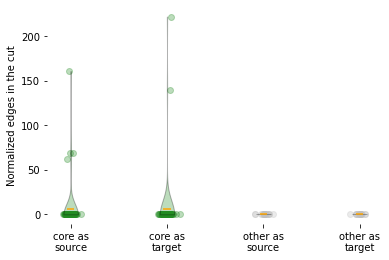

... PageRank centrality
    cores: DescribeResult(nobs=56, minmax=(0.012711864406779662, 0.10577755783743659), mean=0.017857142857142856, variance=0.00039465167992094863, skewness=3.780087138903081, kurtosis=12.685241963545044)
    others: DescribeResult(nobs=17, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  61.651 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


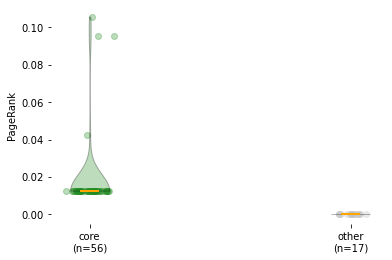

... Manifold Analysis
... Starting attractor analysis
    coloring frames


/opt/conda/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


    finding trajectories
    trajectories lengths: 21.33±19.16 (median:14.00)
... performing dimensionality reduction of the state space (using PCA)
Silhouette Score:
0.48501713569293364
... testing cluster manifolds
area:  SomMoCtx
population: 0
    time: 128007
    cells: 65
... Dynamical Analysis
    population firing: 3.34±2.79 sp/frame
    cells firing rate: 0.05±0.23 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.676413531624167
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 9008
    number of events per sec: 1.7618353755733103
    events duration: 0.090±0.040
    events size: 17.000±6.722
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.20754796714864582
    cluster size threshold: 2
    Total number of

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


    gathering cores from all clusters
    # cores: 47
    # non-cores: 18
    cores per cluster: 3.23±3.33 (min 0, max 13)
    others per cluster: 61.77±3.33 (min 52, max 65)
... Functional correlation analysis (functional structure)
    binary spiketrains
    shape: (65, 128009)
    starting functional adjacency matrix
    full adjacency matrix: (65, 65)
    preparing vertex labels for cores and others
    Degree distributions


/tmp/ipykernel_513/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_513/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=47, minmax=(0.0, 8.0), mean=0.1702127659574468, variance=1.3617021276595747, skewness=6.634888026970373, kurtosis=42.02173913043479)
    Cut edges targeting cores: DescribeResult(nobs=47, minmax=(0.0, 8.0), mean=0.1702127659574468, variance=1.3617021276595747, skewness=6.634888026970373, kurtosis=42.02173913043479)
    Cut edges sourcing from others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.000 p= 0.323
    Kolmogorov-Smirnov Effect Size: 0.021


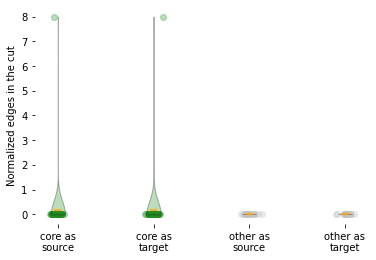

... PageRank centrality
    cores: DescribeResult(nobs=47, minmax=(0.017142857142857144, 0.11428571428571427), mean=0.021276595744680847, variance=0.0003928335441484638, skewness=4.53259797957468, kurtosis=18.544444444444483)
    others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  59.429 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


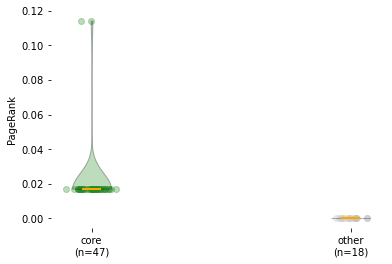

... Manifold Analysis
... Starting attractor analysis
    coloring frames
    finding trajectories
    trajectories lengths: 19.65±18.04 (median:14.00)
... performing dimensionality reduction of the state space (using PCA)


KeyboardInterrupt: 

KeyboardInterrupt: 

In [6]:
# start of spontaneous activity in each mouse (in seconds)
etstart = [3811, 3633, 3323]

all_degrees = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_local_clustering_coefficients = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_core_local_clustering_coefficients = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_pagerank_cores = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_pagerank_others = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }

for imouse,(mousename,areas) in enumerate(area_spiketrains.items()):
    print("\n\n-------------------------\nmouse:",mousename)
    
    # # to reduce computations, use comments here to run the analysis separately on different mice
    # if mousename not in ["Krebs"]:
    #     continue
    # if mousename not in ["Waksman"]:
    #     continue
    # if mousename not in ["Robbins"]:
    #     continue
        
    exp_path = local_path + '%s/'%mousename
    exp_tstart = etstart[imouse]

    # reading behavior data to make statistics about event dependence on it
    # we will use the field 'stimulus' to store the avg motSVD of the frames 
    # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
    faces = sio.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mousename, squeeze_me=True)
    video_timestamps = faces['times'] # same temporal resolution of ephy
    motSVD = faces['motionSVD']
    exp_istart = (np.abs(video_timestamps - exp_tstart)).argmin()    
    motSVD_1c = motSVD[:,0] # only first component
    motSVD_1c[motSVD_1c < -4000] = np.mean(motSVD_1c) # corrections
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(video_timestamps[exp_istart:], motSVD_1c[exp_istart:], linewidth=0.5, color='k')
    fig.savefig(exp_path+"/motSVD_%s.png"%mousename, transparent=True, dpi=900)
    plt.close()
    fig.clear()
    fig.clf()

    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print("area: ",area)
            
            # # to reduce computations, use comments here
            # if area not in ['FrCtx', 'FrMoCtx']:
            # if area not in ['V1']:
            #     continue
                                                
            for ipop,spiketrains in enumerate(probe_populations): 
                print("population:",ipop)

                if mousename=='Waksman' and area=='FrMoCtx' and ipop==1:
                    continue # no events

                # rounding to ms
                # spiketrains = [np.round(sp, 3) for sp in spiketrains] # ms
                spiketrains = [np.round(sp, 2) for sp in spiketrains] # 10ms
                start_time = min([min(st) if len(st) else 0 for st in spiketrains])
                stop_time = max([max(st) if len(st) else 0 for st in spiketrains])
                time = np.arange(start_time,stop_time,frame_duration)
                print("    time:", len(time))
                print("    cells:", len(spiketrains))

                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig(exp_path+'%s_%s_rasterplot.png'%(area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()
                
                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = ophys_cell_ids # here is an alias

                scan_spiketrains = spiketrains
                scan_id = '_%s_%s'%(area,ipop)
                
                # --------------------------------------------------------------------------
                print("... Dynamical Analysis")
                core_reproducibility_perc = 99 # threshold for detecting cores
                %run "dynamical_analysis.ipynb"
                
                # # Match smooth motion energy curve with the cluster it belongs to
                # # Count the number of events belonging to a pattern before and after the change.
                # ccolors,ccounts = np.unique(cluster_color_array, return_counts=True)
                # cluster_events_counts = dict(zip(ccolors,ccounts))
                # Npre_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # Npost_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # for sni in smoothed_beh_indices:
                #     snitime = exp_tstart + sni * frame_duration
                #     snitime_pre = snitime - 0.15 # s
                #     snitime_post = snitime + 0.15 # s
                #     for ievent,(event,ecolor) in enumerate(zip(events,cluster_color_array)):
                #         event_start_time = exp_tstart + event['start'] * frame_duration
                #         if snitime_pre < event_start_time and event_start_time < snitime:
                #             Npre_beh_cluster[ecolor] += 1
                #         if snitime < event_start_time and event_start_time < snitime_post:
                #             Npost_beh_cluster[ecolor] += 1
                # # detail
                # fig = plt.figure()
                # plt.scatter(range(len(Npre_beh_cluster.keys())), Npre_beh_cluster.values(), marker='<', c=list(Npre_beh_cluster.keys()), edgecolors=list(Npre_beh_cluster.keys()), s=1)
                # plt.scatter(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), marker='>', c=list(Npost_beh_cluster.keys()), edgecolors='none', s=1)
                # plt.vlines(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), Npre_beh_cluster.values(), colors=list(Npost_beh_cluster.keys()), linewidths=0.6)
                # plt.ylabel('occurrence')
                # plt.xlabel('Patterns')
                # fig.savefig(exp_path+"/results/Pattern_behavior_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                # # summary
                # Nsame = 0
                # Npost = 0
                # Npre = 0
                # for pre,post in zip(Npre_beh_cluster.values(),Npost_beh_cluster.values()):
                #     if pre==post: Nsame +=1
                #     if pre>post: Npre +=1
                #     if pre<post: Npost +=1
                # fig = plt.figure()
                # plt.bar([0,1,2], [Npre,Nsame,Npost], width=0.8, color='C0')
                # plt.ylabel('occurrences')
                # plt.xlabel('pattern timing relative to movement')
                # plt.xticks(range(3),['before','same','after'])
                # fig.savefig(exp_path+"/results/Pattern_behavior_summary_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()

                # --------------------------------------------------------------------------
                # Functional structure analysis
                # separated by cortical area, color: pagerank, modularity
                perc_corr = 0.6
                %run "functional_analysis.ipynb"
                all_degrees[area].extend(degrees)
                all_local_clustering_coefficients[area].extend(local_clustering_coefficients)
                all_core_local_clustering_coefficients[area].extend(core_local_clustering_coefficients)
                all_pagerank_cores[area].extend(pagerank_cores)
                all_pagerank_others[area].extend(pagerank_others)
                
                # --------------------------------------------------------------------------
                # dimensional reduction, trajectories, and manifold analysis
                print("... Manifold Analysis")
                %run "attractor_analysis.ipynb"
                
    gc.collect()
    print()    

In [ ]:
cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']
cortical_colors = ['tab:olive', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:brown']
# summary figures
for area,acolor in zip(cortical_areas,cortical_colors):
    print("... area:",area)
    # modularity
    print('    Total modularity')
    # figure
    fig, (hmmap, chist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]})
    # hierarchy
    hmmap.scatter( all_degrees[area], all_local_clustering_coefficients[area], marker='o', facecolor=acolor, s=50, edgecolors='none', alpha=0.5) 
    hmmap.set_yscale('log')
    hmmap.set_ylim([0.09,1.1])
    hmmap.set_xscale('log')
    hmmap.set_xlim([0.5,20])
    hmmap.spines['top'].set_visible(False)
    hmmap.spines['right'].set_visible(False)
    hmmap.set_ylabel('LCC')
    hmmap.set_xlabel('degree')
    hmmap.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
    # core lcc histogram
    bins = np.linspace(0.02,0.9,50)
    barheight = (max(all_local_clustering_coefficients[area])-min(all_local_clustering_coefficients[area]))/50
    lcc_hist, lcc_binedges = np.histogram(all_core_local_clustering_coefficients[area], bins)
    chist.barh(bins[:-1], lcc_hist, height=barheight, align='center', color='green', linewidth=0)
    chist.spines['top'].set_visible(False)
    chist.spines['right'].set_visible(False)
    chist.tick_params(axis='x', which='both', bottom=True, top=False, labelsize='x-small')
    chist.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    chist_ticks = chist.get_xticks()
    chist.set_ylim([0.01,1.1])
    chist.set_ylabel('LCC')
    chist.set_xlabel('count')
    chist.yaxis.set_label_position("right")
    chist.spines['top'].set_visible(False)
    chist.spines['right'].set_visible(False)
    chist.spines['bottom'].set_visible(False)
    plt.tight_layout()
    fig.savefig("stringer/7739750/cores_hierarchical_modularity_%s.svg"%(area), transparent=True)
    plt.close()
    fig.clear()
    fig.clf()

    # totals
    if len(all_pagerank_cores[area])>0 and len(all_pagerank_others[area])>0:
        print('    Total PageRank centrality')
        # description
        print("    cores: "+str(stats.describe(all_pagerank_cores[area])) )
        print("    others: "+str(stats.describe(all_pagerank_others[area])) )
        # significativity
        print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.kruskal(all_pagerank_cores[area], all_pagerank_others[area]))
        d,_ = stats.ks_2samp(all_pagerank_cores[area], all_pagerank_others[area]) # non-parametric measure of effect size [0,1]
        print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

        fig, ax = plt.subplots()
        xs = np.random.normal(1, 0.04, len(all_pagerank_cores[area]))
        plt.scatter(xs, all_pagerank_cores[area], alpha=0.3, c='forestgreen')
        xs = np.random.normal(2, 0.04, len(all_pagerank_others[area]))
        plt.scatter(xs, all_pagerank_others[area], alpha=0.3, c='silver')
        vp = ax.violinplot([all_pagerank_cores[area],all_pagerank_others[area]], widths=0.15, showextrema=False, showmedians=True)
        for pc in vp['bodies']:
            pc.set_edgecolor('black')
        for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
            pc.set_facecolor(cb)
        vp['cmedians'].set_color('orange')
        vp['cmedians'].set_linewidth(2.)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.ylabel('PageRank')
        plt.xticks([1, 2], ["core\n(n={:d})".format(len(all_pagerank_cores[area])), "other\n(n={:d})".format(len(all_pagerank_others[area]))])
        fig.savefig("stringer/7739750/global_cores_others_pagerank_all_%s.svg"%(area), transparent=True)
        plt.show()
